In [1]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import SSD300, MultiBoxFeatsMapLoss
from datasets import PascalVOCDataset
from utils import *

In [2]:
# Data parameters
data_folder = './JSON'  # folder with data files
keep_difficult = True  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
iterations = 120000  # number of iterations to train
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [3]:
def train(train_loader, modelA, modelB, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    modelB.train()  # training mode enables dropout
    modelA.eval()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss
    losses_c = AverageMeter()
    losses_l = AverageMeter()
    losses_f = AverageMeter()
    loss_c_list = []
    loss_l_list = []
    loss_f_list = []

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores, feat_maps_B = modelB(images)  # (N, 8732, 4), (N, 8732, n_classes)
        with torch.no_grad():
            _,_, feat_maps_A = modelA(images)

        # Loss
        loss_c, loss_l, loss_f = criterion(predicted_locs, predicted_scores, feat_maps_B, boxes, labels, feat_maps_A)  # scalar
        loss = loss_c+loss_l+loss_f

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()
        losses_c.update(loss_c.item(), images.size(0))
        losses_l.update(loss_l.item(), images.size(0))
        losses_f.update(loss_f.item(), images.size(0))

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            loss_c_list.append(losses_c.avg)
            loss_l_list.append(losses_l.avg)
            loss_f_list.append(losses_f.avg)
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Loss_c {loss_c.val:.4f} ({loss_c.avg:.4f})\t'
                  'Loss_l {loss_l.val:.4f} ({loss_l.avg:.4f})\t'
                  'Loss_f {loss_f.val:.4f} ({loss_f.avg:.4f})\t'.format(epoch, i, len(train_loader), batch_time = batch_time, data_time = data_time, loss = losses, loss_c = losses_c, loss_l = losses_l, loss_f = losses_f))
            
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    return loss_c_list, loss_l_list, loss_f_list

In [4]:
if checkpoint is None:
    start_epoch = 0
    modelB = SSD300(n_classes=n_classes)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in modelB.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
    modelB = checkpoint['model']
    optimizer = checkpoint['optimizer']
# Load modelA
modelA_loc = './Checkpoint/checkpoint_ssd300_2007.pth.tar'
modelA_checkpoint = torch.load(modelA_loc)
modelA = modelA_checkpoint['model']
modelA = modelA.to(device)
# Switch modelA to eval mode
modelA.eval()
    
# Move to default device
modelB = modelB.to(device)
criterion = MultiBoxFeatsMapLoss(priors_cxcy=modelB.priors_cxcy).to(device)

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,
                                 split='train',
                                 year='2012',
                                 keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                            collate_fn=train_dataset.collate_fn, num_workers=workers,
                                            pin_memory=True)  # note that we're passing the collate function here

# Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
# To convert iterations to epochs, divide iterations by the number of iterations per epoch
# The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
epochs = iterations // (len(train_dataset) // batch_size)
decay_lr_at = [it // (len(train_dataset) // batch_size) for it in decay_lr_at]

print('Total epochs: ',epochs)
# Epochs
loss_c_plot = []
loss_l_plot = []
loss_f_plot = []
for epoch in range(start_epoch, epochs):

    # Decay learning rate at particular epochs
    if epoch in decay_lr_at:
        adjust_learning_rate(optimizer, decay_lr_to)

    # One epoch's training
    loss_c, loss_l, loss_f = train(train_loader=train_loader,
                            modelA=modelA,
                            modelB=modelB,
                            criterion=criterion,
                            optimizer=optimizer,
                            epoch=epoch)
    loss_c_plot.extend(loss_c)
    loss_l_plot.extend(loss_l)
    loss_f_plot.extend(loss_f)

    # Save checkpoint
    save_checkpoint(epoch, modelB, optimizer, 'wo_exemplar')


Loaded base model.

Total epochs:  168
Epoch: [0][0/715]	Batch Time 1.637 (1.637)	Data Time 0.264 (0.264)	Loss 25.5284 (25.5284)	Loss_c 22.8558 (22.8558)	Loss_l 0.6867 (0.6867)	Loss_f 1.9858 (1.9858)	
Epoch: [0][200/715]	Batch Time 0.168 (0.179)	Data Time 0.000 (0.001)	Loss 7.6038 (12.0513)	Loss_c 5.2918 (9.1122)	Loss_l 0.6584 (0.7060)	Loss_f 1.6535 (2.2330)	
Epoch: [0][400/715]	Batch Time 0.195 (0.176)	Data Time 0.000 (0.001)	Loss 7.7521 (9.9634)	Loss_c 4.6685 (7.3233)	Loss_l 0.5854 (0.6803)	Loss_f 2.4982 (1.9598)	
Epoch: [0][600/715]	Batch Time 0.182 (0.177)	Data Time 0.000 (0.001)	Loss 7.2205 (9.1195)	Loss_c 5.3149 (6.6160)	Loss_l 0.6200 (0.6643)	Loss_f 1.2855 (1.8392)	
Epoch: [1][0/715]	Batch Time 0.495 (0.495)	Data Time 0.313 (0.313)	Loss 6.8394 (6.8394)	Loss_c 4.7018 (4.7018)	Loss_l 0.5769 (0.5769)	Loss_f 1.5607 (1.5607)	
Epoch: [1][200/715]	Batch Time 0.181 (0.182)	Data Time 0.000 (0.002)	Loss 6.6513 (7.1447)	Loss_c 4.8336 (4.9996)	Loss_l 0.5402 (0.6060)	Loss_f 1.2775 (1.5392)	

Epoch: [13][0/715]	Batch Time 0.535 (0.535)	Data Time 0.349 (0.349)	Loss 3.7436 (3.7436)	Loss_c 2.6753 (2.6753)	Loss_l 0.3571 (0.3571)	Loss_f 0.7112 (0.7112)	
Epoch: [13][200/715]	Batch Time 0.183 (0.184)	Data Time 0.000 (0.002)	Loss 4.1570 (3.6694)	Loss_c 3.3384 (2.7783)	Loss_l 0.5147 (0.3812)	Loss_f 0.3038 (0.5099)	
Epoch: [13][400/715]	Batch Time 0.184 (0.183)	Data Time 0.000 (0.001)	Loss 3.6761 (3.6651)	Loss_c 2.8014 (2.7785)	Loss_l 0.4226 (0.3801)	Loss_f 0.4521 (0.5065)	
Epoch: [13][600/715]	Batch Time 0.181 (0.183)	Data Time 0.000 (0.001)	Loss 3.0709 (3.6466)	Loss_c 2.3115 (2.7619)	Loss_l 0.3913 (0.3800)	Loss_f 0.3681 (0.5047)	
Epoch: [14][0/715]	Batch Time 0.472 (0.472)	Data Time 0.286 (0.286)	Loss 3.7068 (3.7068)	Loss_c 2.8509 (2.8509)	Loss_l 0.4353 (0.4353)	Loss_f 0.4206 (0.4206)	
Epoch: [14][200/715]	Batch Time 0.184 (0.185)	Data Time 0.000 (0.002)	Loss 3.2379 (3.6116)	Loss_c 2.4078 (2.7394)	Loss_l 0.3766 (0.3756)	Loss_f 0.4535 (0.4966)	
Epoch: [14][400/715]	Batch Time 0.183 

Epoch: [26][0/715]	Batch Time 0.507 (0.507)	Data Time 0.321 (0.321)	Loss 3.1017 (3.1017)	Loss_c 2.4024 (2.4024)	Loss_l 0.2817 (0.2817)	Loss_f 0.4176 (0.4176)	
Epoch: [26][200/715]	Batch Time 0.183 (0.184)	Data Time 0.000 (0.002)	Loss 3.6760 (3.1149)	Loss_c 2.9833 (2.4114)	Loss_l 0.3011 (0.3288)	Loss_f 0.3916 (0.3748)	
Epoch: [26][400/715]	Batch Time 0.183 (0.184)	Data Time 0.000 (0.001)	Loss 2.5919 (3.1475)	Loss_c 1.9584 (2.4487)	Loss_l 0.3027 (0.3332)	Loss_f 0.3308 (0.3656)	
Epoch: [26][600/715]	Batch Time 0.184 (0.184)	Data Time 0.000 (0.001)	Loss 3.4785 (3.1454)	Loss_c 2.6450 (2.4437)	Loss_l 0.4418 (0.3314)	Loss_f 0.3918 (0.3704)	
Epoch: [27][0/715]	Batch Time 0.462 (0.462)	Data Time 0.277 (0.277)	Loss 2.7582 (2.7582)	Loss_c 2.0448 (2.0448)	Loss_l 0.2922 (0.2922)	Loss_f 0.4212 (0.4212)	
Epoch: [27][200/715]	Batch Time 0.184 (0.185)	Data Time 0.000 (0.001)	Loss 2.2859 (3.1028)	Loss_c 1.7014 (2.4071)	Loss_l 0.2496 (0.3267)	Loss_f 0.3350 (0.3690)	
Epoch: [27][400/715]	Batch Time 0.185 

Epoch: [39][0/715]	Batch Time 0.412 (0.412)	Data Time 0.223 (0.223)	Loss 2.7901 (2.7901)	Loss_c 2.1764 (2.1764)	Loss_l 0.2880 (0.2880)	Loss_f 0.3258 (0.3258)	
Epoch: [39][200/715]	Batch Time 0.183 (0.185)	Data Time 0.000 (0.001)	Loss 2.9696 (2.8248)	Loss_c 2.2531 (2.2109)	Loss_l 0.4049 (0.2937)	Loss_f 0.3116 (0.3203)	
Epoch: [39][400/715]	Batch Time 0.186 (0.185)	Data Time 0.000 (0.001)	Loss 2.6694 (2.8684)	Loss_c 1.9440 (2.2454)	Loss_l 0.2414 (0.2994)	Loss_f 0.4840 (0.3236)	
Epoch: [39][600/715]	Batch Time 0.183 (0.185)	Data Time 0.000 (0.000)	Loss 2.7104 (2.8771)	Loss_c 2.1172 (2.2504)	Loss_l 0.3190 (0.2992)	Loss_f 0.2742 (0.3275)	
Epoch: [40][0/715]	Batch Time 0.464 (0.464)	Data Time 0.278 (0.278)	Loss 2.5386 (2.5386)	Loss_c 1.9784 (1.9784)	Loss_l 0.2519 (0.2519)	Loss_f 0.3083 (0.3083)	
Epoch: [40][200/715]	Batch Time 0.183 (0.185)	Data Time 0.000 (0.001)	Loss 3.1964 (2.8714)	Loss_c 2.4022 (2.2411)	Loss_l 0.4756 (0.3001)	Loss_f 0.3186 (0.3301)	
Epoch: [40][400/715]	Batch Time 0.182 

Epoch: [52][0/715]	Batch Time 0.452 (0.452)	Data Time 0.242 (0.242)	Loss 2.8294 (2.8294)	Loss_c 2.1196 (2.1196)	Loss_l 0.3073 (0.3073)	Loss_f 0.4025 (0.4025)	
Epoch: [52][200/715]	Batch Time 0.184 (0.185)	Data Time 0.000 (0.001)	Loss 2.7656 (2.7299)	Loss_c 2.1858 (2.1498)	Loss_l 0.2885 (0.2889)	Loss_f 0.2913 (0.2912)	
Epoch: [52][400/715]	Batch Time 0.184 (0.185)	Data Time 0.000 (0.001)	Loss 2.3307 (2.6942)	Loss_c 1.6817 (2.1202)	Loss_l 0.3152 (0.2815)	Loss_f 0.3338 (0.2925)	
Epoch: [52][600/715]	Batch Time 0.184 (0.184)	Data Time 0.000 (0.000)	Loss 2.4062 (2.6945)	Loss_c 1.8330 (2.1201)	Loss_l 0.2611 (0.2813)	Loss_f 0.3121 (0.2931)	
Epoch: [53][0/715]	Batch Time 0.478 (0.478)	Data Time 0.288 (0.288)	Loss 2.0982 (2.0982)	Loss_c 1.6587 (1.6587)	Loss_l 0.2284 (0.2284)	Loss_f 0.2110 (0.2110)	
Epoch: [53][200/715]	Batch Time 0.186 (0.187)	Data Time 0.000 (0.002)	Loss 3.3001 (2.7094)	Loss_c 2.6100 (2.1331)	Loss_l 0.3161 (0.2867)	Loss_f 0.3741 (0.2896)	
Epoch: [53][400/715]	Batch Time 0.185 

Epoch: [65][0/715]	Batch Time 0.540 (0.540)	Data Time 0.349 (0.349)	Loss 3.3935 (3.3935)	Loss_c 2.8932 (2.8932)	Loss_l 0.3398 (0.3398)	Loss_f 0.1605 (0.1605)	
Epoch: [65][200/715]	Batch Time 0.182 (0.184)	Data Time 0.000 (0.002)	Loss 3.2819 (2.5633)	Loss_c 2.6025 (2.0211)	Loss_l 0.3140 (0.2610)	Loss_f 0.3655 (0.2812)	
Epoch: [65][400/715]	Batch Time 0.183 (0.183)	Data Time 0.000 (0.001)	Loss 3.3141 (2.5720)	Loss_c 2.5905 (2.0248)	Loss_l 0.3725 (0.2660)	Loss_f 0.3512 (0.2813)	
Epoch: [65][600/715]	Batch Time 0.182 (0.183)	Data Time 0.000 (0.001)	Loss 2.1815 (2.5714)	Loss_c 1.8066 (2.0218)	Loss_l 0.1609 (0.2666)	Loss_f 0.2140 (0.2831)	
Epoch: [66][0/715]	Batch Time 0.507 (0.507)	Data Time 0.320 (0.320)	Loss 2.9068 (2.9068)	Loss_c 2.2796 (2.2796)	Loss_l 0.3415 (0.3415)	Loss_f 0.2858 (0.2858)	
Epoch: [66][200/715]	Batch Time 0.172 (0.185)	Data Time 0.000 (0.002)	Loss 2.5721 (2.4685)	Loss_c 2.1374 (1.9324)	Loss_l 0.2294 (0.2494)	Loss_f 0.2054 (0.2867)	
Epoch: [66][400/715]	Batch Time 0.174 

Epoch: [78][0/715]	Batch Time 0.636 (0.636)	Data Time 0.442 (0.442)	Loss 2.1700 (2.1700)	Loss_c 1.6995 (1.6995)	Loss_l 0.2535 (0.2535)	Loss_f 0.2169 (0.2169)	
Epoch: [78][200/715]	Batch Time 0.182 (0.184)	Data Time 0.000 (0.002)	Loss 2.2489 (2.4910)	Loss_c 1.6449 (1.9582)	Loss_l 0.2396 (0.2558)	Loss_f 0.3645 (0.2771)	
Epoch: [78][400/715]	Batch Time 0.183 (0.183)	Data Time 0.000 (0.001)	Loss 2.4140 (2.5019)	Loss_c 1.8633 (1.9746)	Loss_l 0.2982 (0.2586)	Loss_f 0.2525 (0.2686)	
Epoch: [78][600/715]	Batch Time 0.186 (0.183)	Data Time 0.000 (0.001)	Loss 1.8234 (2.5053)	Loss_c 1.3127 (1.9775)	Loss_l 0.1314 (0.2579)	Loss_f 0.3792 (0.2699)	
Epoch: [79][0/715]	Batch Time 0.534 (0.534)	Data Time 0.347 (0.347)	Loss 2.3589 (2.3589)	Loss_c 1.8457 (1.8457)	Loss_l 0.2612 (0.2612)	Loss_f 0.2520 (0.2520)	
Epoch: [79][200/715]	Batch Time 0.183 (0.185)	Data Time 0.000 (0.002)	Loss 1.8224 (2.4603)	Loss_c 1.4217 (1.9256)	Loss_l 0.1808 (0.2606)	Loss_f 0.2200 (0.2741)	
Epoch: [79][400/715]	Batch Time 0.183 

Epoch: [91][0/715]	Batch Time 0.471 (0.471)	Data Time 0.294 (0.294)	Loss 2.4172 (2.4172)	Loss_c 1.8157 (1.8157)	Loss_l 0.2612 (0.2612)	Loss_f 0.3404 (0.3404)	
Epoch: [91][200/715]	Batch Time 0.171 (0.172)	Data Time 0.000 (0.002)	Loss 2.1951 (2.3845)	Loss_c 1.7826 (1.8783)	Loss_l 0.2124 (0.2419)	Loss_f 0.2001 (0.2644)	
Epoch: [91][400/715]	Batch Time 0.171 (0.172)	Data Time 0.000 (0.001)	Loss 1.9408 (2.3996)	Loss_c 1.4941 (1.8889)	Loss_l 0.1685 (0.2452)	Loss_f 0.2781 (0.2655)	
Epoch: [91][600/715]	Batch Time 0.171 (0.172)	Data Time 0.000 (0.001)	Loss 2.4980 (2.4098)	Loss_c 1.9847 (1.8980)	Loss_l 0.2627 (0.2481)	Loss_f 0.2506 (0.2637)	
Epoch: [92][0/715]	Batch Time 0.520 (0.520)	Data Time 0.344 (0.344)	Loss 2.8843 (2.8843)	Loss_c 2.4554 (2.4554)	Loss_l 0.2490 (0.2490)	Loss_f 0.1799 (0.1799)	
Epoch: [92][200/715]	Batch Time 0.172 (0.173)	Data Time 0.000 (0.002)	Loss 2.0105 (2.3989)	Loss_c 1.5602 (1.9008)	Loss_l 0.1475 (0.2469)	Loss_f 0.3028 (0.2512)	
Epoch: [92][400/715]	Batch Time 0.170 

Epoch: [103][600/715]	Batch Time 0.171 (0.169)	Data Time 0.000 (0.001)	Loss 2.3725 (2.3214)	Loss_c 1.8077 (1.8244)	Loss_l 0.2453 (0.2368)	Loss_f 0.3194 (0.2602)	
Epoch: [104][0/715]	Batch Time 0.501 (0.501)	Data Time 0.330 (0.330)	Loss 2.2443 (2.2443)	Loss_c 1.8469 (1.8469)	Loss_l 0.2288 (0.2288)	Loss_f 0.1687 (0.1687)	
Epoch: [104][200/715]	Batch Time 0.169 (0.170)	Data Time 0.000 (0.002)	Loss 2.3920 (2.3275)	Loss_c 1.9189 (1.8356)	Loss_l 0.3220 (0.2375)	Loss_f 0.1511 (0.2544)	
Epoch: [104][400/715]	Batch Time 0.166 (0.169)	Data Time 0.000 (0.001)	Loss 2.2267 (2.3233)	Loss_c 1.7270 (1.8278)	Loss_l 0.2183 (0.2393)	Loss_f 0.2813 (0.2563)	
Epoch: [104][600/715]	Batch Time 0.169 (0.169)	Data Time 0.000 (0.001)	Loss 1.6698 (2.3284)	Loss_c 1.3095 (1.8292)	Loss_l 0.1601 (0.2385)	Loss_f 0.2002 (0.2606)	
Epoch: [105][0/715]	Batch Time 0.445 (0.445)	Data Time 0.272 (0.272)	Loss 3.0102 (3.0102)	Loss_c 2.4915 (2.4915)	Loss_l 0.2622 (0.2622)	Loss_f 0.2566 (0.2566)	
Epoch: [105][200/715]	Batch Time

Epoch: [116][400/715]	Batch Time 0.167 (0.169)	Data Time 0.000 (0.001)	Loss 1.9652 (2.0221)	Loss_c 1.5474 (1.5811)	Loss_l 0.2356 (0.2095)	Loss_f 0.1822 (0.2315)	
Epoch: [116][600/715]	Batch Time 0.169 (0.169)	Data Time 0.000 (0.001)	Loss 1.5061 (2.0055)	Loss_c 1.0679 (1.5655)	Loss_l 0.1752 (0.2091)	Loss_f 0.2630 (0.2308)	
Epoch: [117][0/715]	Batch Time 0.429 (0.429)	Data Time 0.259 (0.259)	Loss 2.3016 (2.3016)	Loss_c 1.8236 (1.8236)	Loss_l 0.2881 (0.2881)	Loss_f 0.1899 (0.1899)	
Epoch: [117][200/715]	Batch Time 0.170 (0.170)	Data Time 0.000 (0.001)	Loss 1.6079 (1.9782)	Loss_c 1.2397 (1.5375)	Loss_l 0.1526 (0.2120)	Loss_f 0.2156 (0.2287)	
Epoch: [117][400/715]	Batch Time 0.169 (0.169)	Data Time 0.000 (0.001)	Loss 2.6332 (2.0024)	Loss_c 2.1166 (1.5608)	Loss_l 0.3556 (0.2130)	Loss_f 0.1611 (0.2285)	
Epoch: [117][600/715]	Batch Time 0.170 (0.169)	Data Time 0.000 (0.001)	Loss 1.8404 (2.0100)	Loss_c 1.4611 (1.5686)	Loss_l 0.1630 (0.2129)	Loss_f 0.2163 (0.2285)	
Epoch: [118][0/715]	Batch Time

Epoch: [129][200/715]	Batch Time 0.170 (0.170)	Data Time 0.000 (0.001)	Loss 1.6161 (1.9476)	Loss_c 1.2211 (1.5239)	Loss_l 0.1521 (0.2025)	Loss_f 0.2430 (0.2212)	
Epoch: [129][400/715]	Batch Time 0.168 (0.169)	Data Time 0.000 (0.001)	Loss 1.9118 (1.9634)	Loss_c 1.4480 (1.5312)	Loss_l 0.2234 (0.2091)	Loss_f 0.2404 (0.2230)	
Epoch: [129][600/715]	Batch Time 0.169 (0.169)	Data Time 0.000 (0.001)	Loss 2.2578 (1.9598)	Loss_c 1.8349 (1.5271)	Loss_l 0.2115 (0.2077)	Loss_f 0.2114 (0.2251)	
Epoch: [130][0/715]	Batch Time 0.463 (0.463)	Data Time 0.294 (0.294)	Loss 2.4175 (2.4175)	Loss_c 2.0251 (2.0251)	Loss_l 0.2302 (0.2302)	Loss_f 0.1622 (0.1622)	
Epoch: [130][200/715]	Batch Time 0.168 (0.170)	Data Time 0.000 (0.002)	Loss 1.4242 (1.9556)	Loss_c 1.1038 (1.5157)	Loss_l 0.1160 (0.2107)	Loss_f 0.2044 (0.2292)	
Epoch: [130][400/715]	Batch Time 0.169 (0.169)	Data Time 0.000 (0.001)	Loss 1.5292 (1.9553)	Loss_c 1.1766 (1.5188)	Loss_l 0.0905 (0.2089)	Loss_f 0.2621 (0.2277)	
Epoch: [130][600/715]	Batch Ti

Epoch: [142][0/715]	Batch Time 0.427 (0.427)	Data Time 0.254 (0.254)	Loss 1.7988 (1.7988)	Loss_c 1.3555 (1.3555)	Loss_l 0.2080 (0.2080)	Loss_f 0.2353 (0.2353)	
Epoch: [142][200/715]	Batch Time 0.169 (0.170)	Data Time 0.000 (0.001)	Loss 1.6799 (1.9721)	Loss_c 1.3168 (1.5364)	Loss_l 0.1376 (0.2116)	Loss_f 0.2255 (0.2240)	
Epoch: [142][400/715]	Batch Time 0.168 (0.169)	Data Time 0.000 (0.001)	Loss 1.5088 (1.9244)	Loss_c 1.1440 (1.4951)	Loss_l 0.1183 (0.2023)	Loss_f 0.2466 (0.2270)	
Epoch: [142][600/715]	Batch Time 0.168 (0.169)	Data Time 0.000 (0.001)	Loss 1.8520 (1.9218)	Loss_c 1.3983 (1.4907)	Loss_l 0.1791 (0.2029)	Loss_f 0.2746 (0.2282)	
Epoch: [143][0/715]	Batch Time 0.478 (0.478)	Data Time 0.306 (0.306)	Loss 1.9177 (1.9177)	Loss_c 1.5390 (1.5390)	Loss_l 0.2269 (0.2269)	Loss_f 0.1518 (0.1518)	
Epoch: [143][200/715]	Batch Time 0.170 (0.170)	Data Time 0.000 (0.002)	Loss 2.1669 (1.8917)	Loss_c 1.6329 (1.4626)	Loss_l 0.2188 (0.1972)	Loss_f 0.3152 (0.2318)	
Epoch: [143][400/715]	Batch Time

Epoch: [154][600/715]	Batch Time 0.168 (0.169)	Data Time 0.000 (0.001)	Loss 2.4247 (1.9088)	Loss_c 1.8561 (1.4807)	Loss_l 0.2849 (0.2035)	Loss_f 0.2837 (0.2246)	
Epoch: [155][0/715]	Batch Time 0.613 (0.613)	Data Time 0.446 (0.446)	Loss 1.5031 (1.5031)	Loss_c 1.1290 (1.1290)	Loss_l 0.1816 (0.1816)	Loss_f 0.1924 (0.1924)	
Epoch: [155][200/715]	Batch Time 0.168 (0.171)	Data Time 0.000 (0.002)	Loss 2.0549 (1.9184)	Loss_c 1.5542 (1.4878)	Loss_l 0.2260 (0.2029)	Loss_f 0.2746 (0.2278)	
Epoch: [155][400/715]	Batch Time 0.168 (0.170)	Data Time 0.000 (0.001)	Loss 1.4784 (1.9331)	Loss_c 1.1657 (1.5007)	Loss_l 0.1195 (0.2047)	Loss_f 0.1932 (0.2277)	
Epoch: [155][600/715]	Batch Time 0.169 (0.169)	Data Time 0.000 (0.001)	Loss 2.4561 (1.9205)	Loss_c 1.9195 (1.4912)	Loss_l 0.3180 (0.2020)	Loss_f 0.2186 (0.2273)	
Epoch: [156][0/715]	Batch Time 0.433 (0.433)	Data Time 0.264 (0.264)	Loss 1.9922 (1.9922)	Loss_c 1.6131 (1.6131)	Loss_l 0.2182 (0.2182)	Loss_f 0.1609 (0.1609)	
Epoch: [156][200/715]	Batch Time

Epoch: [167][400/715]	Batch Time 0.169 (0.169)	Data Time 0.000 (0.001)	Loss 1.7250 (1.9311)	Loss_c 1.2683 (1.5048)	Loss_l 0.1668 (0.2040)	Loss_f 0.2899 (0.2223)	
Epoch: [167][600/715]	Batch Time 0.168 (0.169)	Data Time 0.000 (0.001)	Loss 1.6200 (1.9138)	Loss_c 1.3030 (1.4871)	Loss_l 0.1165 (0.2015)	Loss_f 0.2004 (0.2252)	


In [5]:
from matplotlib import pyplot as plt

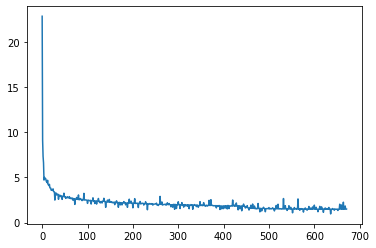

In [6]:
plt.plot(loss_c_plot)

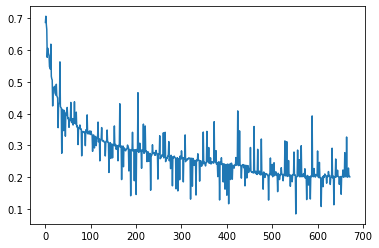

In [7]:
plt.plot(loss_l_plot)

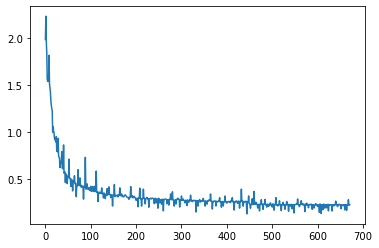

In [8]:
plt.plot(loss_f_plot)